In [2]:
import sys
sys.path.append(r'C:\Users\Acer\Desktop\AL-Emotion\models')

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from improved_emotion_recognition import ImprovedEmotionRecognitionModel, ImprovedTransformerEmotionModel, CustomDataset
from progressive_emotion_training import device

GPU Configuration
PyTorch version: 2.7.1+cu126
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU
Number of GPUs: 1
Using device: cuda


C:\Users\Acer\miniconda3\envs\AI_git\Lib\site-packages\torch\__init__.py:1240: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\tensor\python_tensor.cpp:436.)
  _C._set_default_tensor_type(t)


In [4]:
import sys
print(sys.executable)

C:\Users\Acer\miniconda3\envs\AI_git\python.exe


In [5]:
# Set up matplotlib for notebook display
import matplotlib
matplotlib.use('nbAgg')  # Use notebook backend
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# Load the trained progressive model
print("Loading progressive model...")

# Load checkpoint without weights_only to get sklearn objects
checkpoint = torch.load(r"C:\Users\Acer\Desktop\AL-Emotion\models\progressive_model_stage2.pth", weights_only=False)

# Initialize the model wrapper
model = ImprovedEmotionRecognitionModel()

# Create the transformer model instance
# We need to determine the feature size from the vectorizers
tfidf_features = len(checkpoint['vectorizers']['tfidf'].get_feature_names_out())
count_features = len(checkpoint['vectorizers']['count'].get_feature_names_out())
total_features = tfidf_features + count_features

print(f"Feature dimensions: TF-IDF={tfidf_features}, Count={count_features}, Total={total_features}")

model.model = ImprovedTransformerEmotionModel(
    text_feature_size=total_features,
    num_classes=len(checkpoint['label_encoder'].classes_),
    d_model=512,
    nhead=8,
    num_layers=4,
    dropout=0.2
).to(device)

# Load the state dict
model.model.load_state_dict(checkpoint['model_state_dict'])

# Load the vectorizers and label encoder
model.tfidf_vectorizer = checkpoint['vectorizers']['tfidf']
model.count_vectorizer = checkpoint['vectorizers']['count']
model.label_encoder = checkpoint['label_encoder']

# Set model to evaluation mode
model.model.eval()

print("Model loaded successfully!")
print(f"Model parameters: {sum(p.numel() for p in model.model.parameters()):,}")

Loading progressive model...
Feature dimensions: TF-IDF=2000, Count=1000, Total=3000
Model loaded successfully!
Model parameters: 15,331,594


In [9]:
# Load test datasets
print("\nLoading test datasets...")
clean_test_df = pd.read_csv(r"C:\Users\Acer\Desktop\AL-Emotion\data\datasets\student_emotion_dataset_test_20k_balanced.csv")
noisy_test_df = pd.read_csv(r"C:\Users\Acer\Desktop\AL-Emotion\data\datasets\student_emotion_dataset_test_20k_noisy.csv")

print(f"Clean test dataset: {len(clean_test_df)} samples")
print(f"Noisy test dataset: {len(noisy_test_df)} samples")


Loading test datasets...
Clean test dataset: 20000 samples
Noisy test dataset: 20000 samples


In [10]:
# Prepare features for both test datasets
print("Preparing test features...")
X_clean_test = model.enhanced_feature_preparation(clean_test_df, fit_vectorizer=False, augment=False)
X_noisy_test = model.enhanced_feature_preparation(noisy_test_df, fit_vectorizer=False, augment=False)

# Prepare labels
y_clean_test = model.label_encoder.transform(clean_test_df['emotion'])
y_noisy_test = model.label_encoder.transform(noisy_test_df['emotion'])

# Create datasets
clean_test_dataset = CustomDataset(torch.FloatTensor(X_clean_test), torch.LongTensor(y_clean_test))
noisy_test_dataset = CustomDataset(torch.FloatTensor(X_noisy_test), torch.LongTensor(y_noisy_test))

# Create dataloaders
clean_test_loader = DataLoader(clean_test_dataset, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)
noisy_test_loader = DataLoader(noisy_test_dataset, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

print(f"Clean test features: {X_clean_test.shape}")
print(f"Noisy test features: {X_noisy_test.shape}")

Preparing test features...
Preparing enhanced features...
Enhanced feature dimensions: 3000
Preparing enhanced features...
Enhanced feature dimensions: 3000
Clean test features: (20000, 3000)
Noisy test features: (20000, 3000)


In [11]:
def evaluate_model_silent(model, test_loader, dataset_name):
    """Evaluate model without printing results"""
    model.model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for text_batch, labels in test_loader:
            text_batch = text_batch.to(device)
            labels = labels.to(device)
            
            outputs = model.model(text_batch)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    # Calculate metrics
    accuracy = sum(1 for p, l in zip(all_predictions, all_labels) if p == l) / len(all_labels)
    class_report = classification_report(all_labels, all_predictions, output_dict=True)
    
    # ROC-AUC scores
    all_probabilities = np.array(all_probabilities)
    roc_auc_scores = []
    for i in range(all_probabilities.shape[1]):
        roc_auc_scores.append(roc_auc_score(
            (np.array(all_labels) == i).astype(int), 
            all_probabilities[:, i]
        ))
    
    return {
        'predictions': all_predictions,
        'labels': all_labels,
        'probabilities': all_probabilities,
        'accuracy': accuracy,
        'class_report': class_report,
        'roc_auc_scores': roc_auc_scores,
        'mean_roc_auc': np.mean(roc_auc_scores)
    }

# Then use the silent version:
clean_results = evaluate_model_silent(model, clean_test_loader, "CLEAN TEST DATA")
noisy_results = evaluate_model_silent(model, noisy_test_loader, "NOISY TEST DATA")

# Combined evaluation (both datasets together)
print(f"\n{'='*60}")
print("COMBINED EVALUATION (Clean + Noisy)")
print(f"{'='*60}")

# Combine results
all_predictions = clean_results['predictions'] + noisy_results['predictions']
all_labels = clean_results['labels'] + noisy_results['labels']
all_probabilities = np.vstack([clean_results['probabilities'], noisy_results['probabilities']])

# Calculate combined metrics
combined_accuracy = sum(1 for p, l in zip(all_predictions, all_labels) if p == l) / len(all_labels)
combined_class_report = classification_report(all_labels, all_predictions, output_dict=True)

print(f"Combined Accuracy: {combined_accuracy:.4f}")
print(f"Combined Macro F1: {combined_class_report['macro avg']['f1-score']:.4f}")
print(f"Combined Weighted F1: {combined_class_report['weighted avg']['f1-score']:.4f}")


COMBINED EVALUATION (Clean + Noisy)
Combined Accuracy: 0.8901
Combined Macro F1: 0.8907
Combined Weighted F1: 0.8905


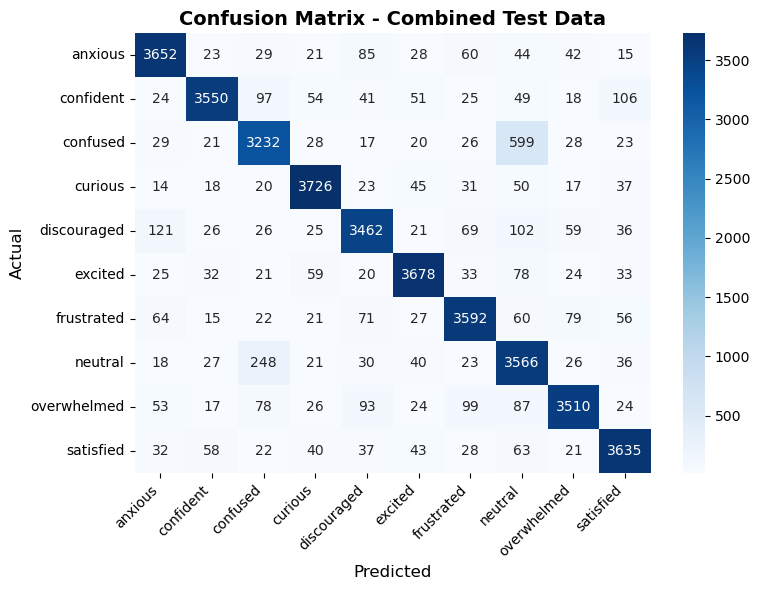


Per-class accuracy for Confusion Matrix - Combined Test Data:
anxious     : 91.32%
confident   : 88.42%
confused    : 80.34%
curious     : 93.59%
discouraged : 87.71%
excited     : 91.88%
frustrated  : 89.64%
neutral     : 88.38%
overwhelmed : 87.51%
satisfied   : 91.35%


In [12]:
def plot_confusion_matrix(y_true, y_pred, title, class_names):
    """Plot confusion matrix with better styling"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))  # Reduced size from (12, 10) to (8, 6)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title, fontsize=14, fontweight='bold')  # Reduced font size
    plt.xlabel('Predicted', fontsize=12)  # Reduced font size
    plt.ylabel('Actual', fontsize=12)  # Reduced font size
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Print per-class accuracy
    print(f"\nPer-class accuracy for {title}:")
    for i, emotion in enumerate(class_names):
        class_acc = cm[i, i] / cm[i, :].sum() * 100
        print(f"{emotion:12}: {class_acc:.2f}%")

# Plot confusion matrix only for combined dataset
class_names = model.label_encoder.classes_

# Combined confusion matrix (only this one)
plot_confusion_matrix(all_labels, all_predictions, 
                     "Confusion Matrix - Combined Test Data", class_names)

Clean emotions: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Noisy emotions: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Class names: ['anxious' 'confident' 'confused' 'curious' 'discouraged' 'excited'
 'frustrated' 'neutral' 'overwhelmed' 'satisfied']


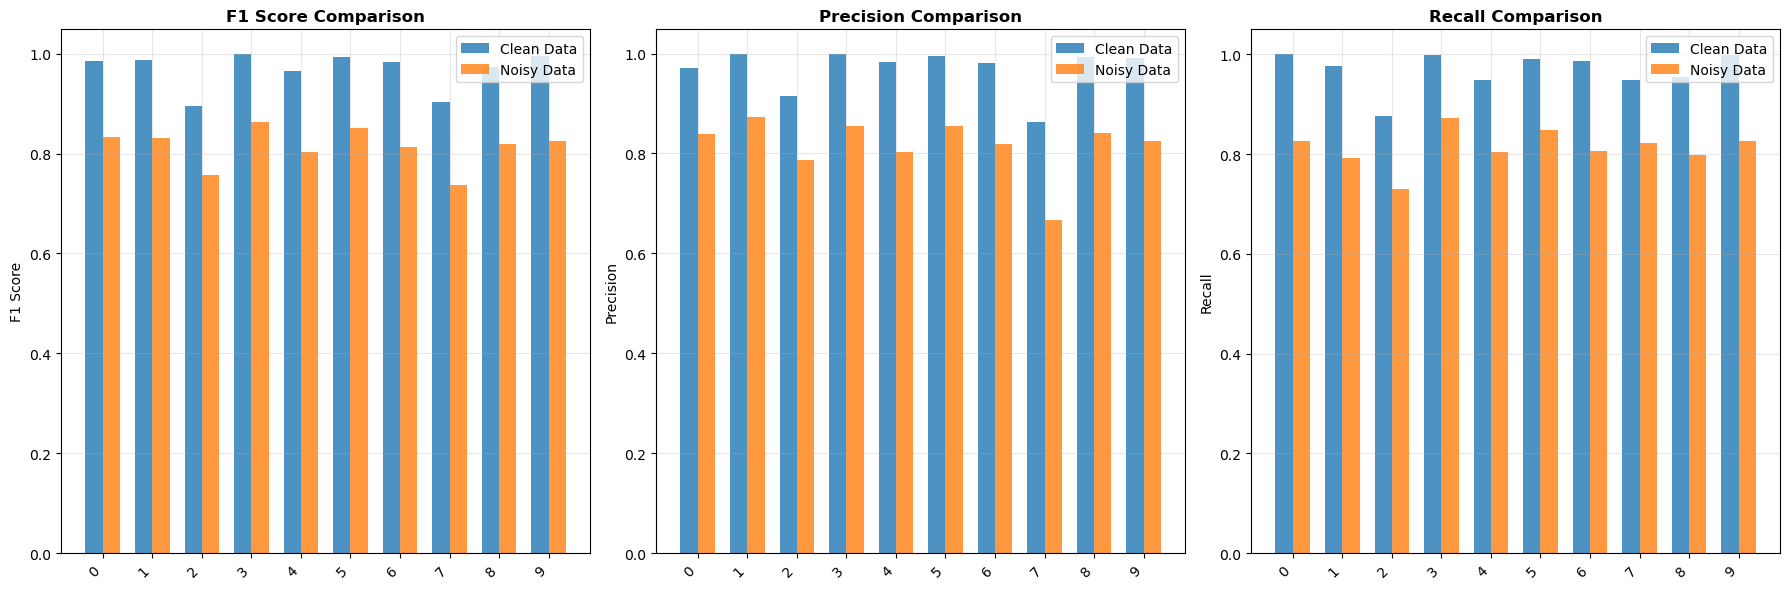


PER-CLASS PERFORMANCE COMPARISON
Emotion      Clean F1   Noisy F1   Clean Prec   Noisy Prec   Clean Rec  Noisy Rec 
--------------------------------------------------------------------------------
0            0.985      0.832      0.970        0.838        1.000      0.826     
1            0.988      0.830      0.998        0.872        0.977      0.792     
2            0.896      0.757      0.916        0.786        0.877      0.731     
3            0.999      0.864      0.999        0.855        0.999      0.872     
4            0.966      0.803      0.983        0.803        0.949      0.803     
5            0.993      0.851      0.995        0.854        0.990      0.848     
6            0.984      0.813      0.981        0.820        0.987      0.806     
7            0.903      0.736      0.863        0.668        0.948      0.821     
8            0.973      0.819      0.993        0.842        0.954      0.797     
9            0.995      0.826      0.990        0.825  

In [13]:
def analyze_per_class_performance(clean_results, noisy_results, class_names):
    """Compare per-class performance between clean and noisy data"""
    
    # Get the actual emotion names from the class report (they might be in different order)
    clean_emotions = list(clean_results['class_report'].keys())
    noisy_emotions = list(noisy_results['class_report'].keys())
    
    # Filter out non-emotion keys (like 'accuracy', 'macro avg', etc.)
    clean_emotions = [e for e in clean_emotions if e not in ['accuracy', 'macro avg', 'weighted avg']]
    noisy_emotions = [e for e in noisy_emotions if e not in ['accuracy', 'macro avg', 'weighted avg']]
    
    print(f"Clean emotions: {clean_emotions}")
    print(f"Noisy emotions: {noisy_emotions}")
    print(f"Class names: {class_names}")
    
    # Extract per-class metrics using the actual emotion names
    clean_f1 = [clean_results['class_report'][emotion]['f1-score'] for emotion in clean_emotions]
    noisy_f1 = [noisy_results['class_report'][emotion]['f1-score'] for emotion in noisy_emotions]
    
    clean_precision = [clean_results['class_report'][emotion]['precision'] for emotion in clean_emotions]
    noisy_precision = [noisy_results['class_report'][emotion]['precision'] for emotion in noisy_emotions]
    
    clean_recall = [clean_results['class_report'][emotion]['recall'] for emotion in clean_emotions]
    noisy_recall = [noisy_results['class_report'][emotion]['recall'] for emotion in noisy_emotions]
    
    # Create comparison plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    x = np.arange(len(clean_emotions))
    width = 0.35
    
    # F1 Score comparison
    axes[0].bar(x - width/2, clean_f1, width, label='Clean Data', alpha=0.8)
    axes[0].bar(x + width/2, noisy_f1, width, label='Noisy Data', alpha=0.8)
    axes[0].set_title('F1 Score Comparison', fontweight='bold')
    axes[0].set_ylabel('F1 Score')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(clean_emotions, rotation=45, ha='right')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Precision comparison
    axes[1].bar(x - width/2, clean_precision, width, label='Clean Data', alpha=0.8)
    axes[1].bar(x + width/2, noisy_precision, width, label='Noisy Data', alpha=0.8)
    axes[1].set_title('Precision Comparison', fontweight='bold')
    axes[1].set_ylabel('Precision')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(clean_emotions, rotation=45, ha='right')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Recall comparison
    axes[2].bar(x - width/2, clean_recall, width, label='Clean Data', alpha=0.8)
    axes[2].bar(x + width/2, noisy_recall, width, label='Noisy Data', alpha=0.8)
    axes[2].set_title('Recall Comparison', fontweight='bold')
    axes[2].set_ylabel('Recall')
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(clean_emotions, rotation=45, ha='right')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print(f"\n{'='*80}")
    print("PER-CLASS PERFORMANCE COMPARISON")
    print(f"{'='*80}")
    print(f"{'Emotion':<12} {'Clean F1':<10} {'Noisy F1':<10} {'Clean Prec':<12} {'Noisy Prec':<12} {'Clean Rec':<10} {'Noisy Rec':<10}")
    print("-" * 80)
    
    for i, emotion in enumerate(clean_emotions):
        print(f"{emotion:<12} {clean_f1[i]:<10.3f} {noisy_f1[i]:<10.3f} {clean_precision[i]:<12.3f} {noisy_precision[i]:<12.3f} {clean_recall[i]:<10.3f} {noisy_recall[i]:<10.3f}")

# Run the analysis
analyze_per_class_performance(clean_results, noisy_results, class_names)

In [14]:
def analyze_classification_examples_both_datasets(clean_results, noisy_results, clean_test_df, noisy_test_df, class_names):
    """Display examples from both clean and noisy datasets for correct and incorrect classifications"""
    
    print("="*80)
    print("CLASSIFICATION EXAMPLES ANALYSIS - BOTH DATASETS")
    print("="*80)
    
    # Find misclassified and correct examples for each dataset
    clean_misclassified = [i for i, (pred, true) in enumerate(zip(clean_results['predictions'], clean_results['labels'])) if pred != true]
    clean_correct = [i for i, (pred, true) in enumerate(zip(clean_results['predictions'], clean_results['labels'])) if pred == true]
    
    noisy_misclassified = [i for i, (pred, true) in enumerate(zip(noisy_results['predictions'], noisy_results['labels'])) if pred != true]
    noisy_correct = [i for i, (pred, true) in enumerate(zip(noisy_results['predictions'], noisy_results['labels'])) if pred == true]

    # Display misclassified examples from both datasets
    print(f"\nMISCLASSIFIED QUERIES:")
    print("="*80)

    
    for i, idx in enumerate(clean_misclassified[:3]):
        query = clean_test_df.iloc[idx]['current_query']
        true_emotion = clean_test_df.iloc[idx]['emotion']
        pred_emotion = class_names[clean_results['predictions'][idx]]
        true_label = clean_results['labels'][idx]
        pred_label = clean_results['predictions'][idx]
        confidence = clean_results['probabilities'][idx][pred_label]
        
        print(f"{i+1}. Query: '{query[:70]}{'...' if len(query) > 70 else ''}'")
        print(f"   True: {true_emotion} → Predicted: {pred_emotion}")
        print(f"   Confidence: {confidence:.3f}")
        print()
    
    for i, idx in enumerate(noisy_misclassified[:3]):
        query = noisy_test_df.iloc[idx]['current_query']
        true_emotion = noisy_test_df.iloc[idx]['emotion']
        pred_emotion = class_names[noisy_results['predictions'][idx]]
        true_label = noisy_results['labels'][idx]
        pred_label = noisy_results['predictions'][idx]
        confidence = noisy_results['probabilities'][idx][pred_label]
        
        print(f"{i+1}. Query: '{query[:70]}{'...' if len(query) > 70 else ''}'")
        print(f"   True: {true_emotion} → Predicted: {pred_emotion}")
        print(f"   Confidence: {confidence:.3f}")
        print()
    
    # Display correctly classified examples from both datasets
    print(f"\nCORRECTLY CLASSIFIED QUERIES:")
    print("="*80)
    
    for i, idx in enumerate(clean_correct[:3]):
        query = clean_test_df.iloc[idx]['current_query']
        true_emotion = clean_test_df.iloc[idx]['emotion']
        pred_emotion = class_names[clean_results['predictions'][idx]]
        true_label = clean_results['labels'][idx]
        pred_label = clean_results['predictions'][idx]
        confidence = clean_results['probabilities'][idx][pred_label]
        
        print(f"{i+1}. Query: '{query[:70]}{'...' if len(query) > 70 else ''}'")
        print(f"   Emotion: {true_emotion}")
        print(f"   Confidence: {confidence:.3f}")
        print()
    
    for i, idx in enumerate(noisy_correct[:3]):
        query = noisy_test_df.iloc[idx]['current_query']
        true_emotion = noisy_test_df.iloc[idx]['emotion']
        pred_emotion = class_names[noisy_results['predictions'][idx]]
        true_label = noisy_results['labels'][idx]
        pred_label = noisy_results['predictions'][idx]
        confidence = noisy_results['probabilities'][idx][pred_label]
        
        print(f"{i+1}. Query: '{query[:70]}{'...' if len(query) > 70 else ''}'")
        print(f"   Emotion: {true_emotion}")
        print(f"   Confidence: {confidence:.3f}")
        print()
    
    # Compare confidence distributions
    print(f"\nCONFIDENCE ANALYSIS:")
    print("="*80)
    

    # Show most confused emotion pairs for each dataset
    print(f"\n MOST CONFUSED EMOTION PAIRS:")
    print("="*80)
    
    # Clean dataset confusion patterns
    clean_confusion = {}
    for idx in clean_misclassified:
        true_emotion = clean_test_df.iloc[idx]['emotion']
        pred_emotion = class_names[clean_results['predictions'][idx]]
        pair = (true_emotion, pred_emotion)
        clean_confusion[pair] = clean_confusion.get(pair, 0) + 1
    
    print(f"Clean Dataset - Top 5 confusions:")
    for (true, pred), count in sorted(clean_confusion.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"  {true} → {pred}: {count} times")
    
    # Noisy dataset confusion patterns
    noisy_confusion = {}
    for idx in noisy_misclassified:
        true_emotion = noisy_test_df.iloc[idx]['emotion']
        pred_emotion = class_names[noisy_results['predictions'][idx]]
        pair = (true_emotion, pred_emotion)
        noisy_confusion[pair] = noisy_confusion.get(pair, 0) + 1
    
    print(f"\nNoisy Dataset - Top 5 confusions:")
    for (true, pred), count in sorted(noisy_confusion.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"  {true} → {pred}: {count} times")

# Run the analysis
analyze_classification_examples_both_datasets(clean_results, noisy_results, clean_test_df, noisy_test_df, class_names)

CLASSIFICATION EXAMPLES ANALYSIS - BOTH DATASETS

MISCLASSIFIED QUERIES:
1. Query: 'I can't grasp how data science and machine learning applications works...'
   True: overwhelmed → Predicted: anxious
   Confidence: 0.333

2. Query: 'I need guidance on behavioral economics and decision theory'
   True: confused → Predicted: neutral
   Confidence: 0.448

3. Query: 'I'm new to history and this is too much at once'
   True: overwhelmed → Predicted: anxious
   Confidence: 0.526

1. Query: 'I can't grasp how systems biota biology network analysis - i feel diso...'
   True: confused → Predicted: overwhelmed
   Confidence: 0.722

2. Query: 'During working along my you my work?'
   True: neutral → Predicted: satisfied
   Confidence: 0.376

3. Query: 'I'm prepare preparing for my upcoming psychometric_test and how embody...'
   True: curious → Predicted: excited
   Confidence: 0.666


CORRECTLY CLASSIFIED QUERIES:
1. Query: 'I want to master biomedical engineering and medical devices - i'm exci

In [15]:
def emotion_demo():
    """Interactive demo for emotion prediction"""
    print("="*60)
    print("EMOTION RECOGNITION DEMO")
    print("="*60)
    print("Enter student queries to predict emotions.")
    print("Type 'quit' to exit the demo.\n")
    
    model.model.eval()
    
    while True:
        # Get user input
        query = input("Enter student query: ").strip()
        
        if query.lower() in ['quit', 'exit', 'q']:
            print("Demo ended. Goodbye!")
            break
        
        if not query:
            print("Please enter a valid query.\n")
            continue
        
        # Prepare the query
        try:
            # Create a dummy dataframe with the query
            demo_df = pd.DataFrame({'current_query': [query]})
            
            # Prepare features
            features = model.enhanced_feature_preparation(demo_df, fit_vectorizer=False, augment=False)
            
            # Convert to tensor
            input_tensor = torch.FloatTensor(features).to(device)
            
            # Get prediction
            with torch.no_grad():
                outputs = model.model(input_tensor)
                probabilities = F.softmax(outputs, dim=1)
                predicted_class = torch.argmax(outputs, dim=1).item()
                confidence = probabilities[0][predicted_class].item()
            
            # Get top 3 predictions
            top3_probs, top3_indices = torch.topk(probabilities[0], 3)
            
            # Display results
            print(f"\nPrediction Results:")
            print(f"   Primary Emotion: {model.label_encoder.classes_[predicted_class]}")
            print(f"   Confidence: {confidence:.2%}")
            
            print(f"\nTop 3 Predictions:")
            for i, (prob, idx) in enumerate(zip(top3_probs, top3_indices)):
                emotion = model.label_encoder.classes_[idx.item()]
                print(f"   {i+1}. {emotion:12}: {prob.item():.2%}")
            
            print(f"\nQuery: '{query}'")
            print("-" * 60)
            
        except Exception as e:
            print(f"Error processing query: {e}")
            print("Please try a different query.\n")

# Run the demo
emotion_demo()

EMOTION RECOGNITION DEMO
Enter student queries to predict emotions.
Type 'quit' to exit the demo.



KeyboardInterrupt: Interrupted by user